# Testing
### Bevölkerung nach Zivilstand, Geschlecht, Alter und Stadtquartier, seit 1993

Zivilstand der Bevölkerung nach Geschlecht, Alter und Stadtquartier, seit 1993.
Datum: 15.03.2022


### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [27]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io


In [28]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [29]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [30]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [31]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [32]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 3 datenstand:  1 time.struct_time(tm_year=2022, tm_mon=3, tm_mday=16, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=2, tm_yday=75, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [33]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [34]:
package_name = "bev_bestand_jahr_quartier_zivilstand_ag_geschl_od3310"

In [35]:
dataset_name = "BEV331OD3310.csv"

**Statische Pfade in DWH-Dropzones**

In [36]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [37]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [38]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [39]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [40]:
from IPython.display import Markdown as md

In [41]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_quartier_zivilstand_ag_geschl_od3310 

In [42]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_zivilstand_ag_geschl_od3310 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [43]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [44]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_quartier_zivilstand_ag_geschl_od3310/download/BEV331OD3310.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [45]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr    datetime64[ns]
Ziv2Sort                    int64
Ziv2Lang                   object
SexCd                       int64
SexLang                    object
QuarSort                    int64
QuarLang                   object
AlterVSort                  int64
AlterV05Sort                int64
AlterV05Kurz               object
AlterV10Sort                int64
AlterV10Kurz               object
AlterV20Sort                int64
AlterV20Kurz               object
AnzBestWir                  int64
dtype: object

Berechne weitere Attribute falls notwendig

In [46]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
Ziv2Sort                        int64
Ziv2Lang                       object
SexCd                           int64
SexLang                        object
QuarSort                        int64
QuarLang                       object
AlterVSort                      int64
AlterV05Sort                    int64
AlterV05Kurz                   object
AlterV10Sort                    int64
AlterV10Kurz                   object
AlterV20Sort                    int64
AlterV20Kurz                   object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [47]:
#data2betested.head(6)

In [48]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
Ziv2Sort                        int64
Ziv2Lang                       object
SexCd                           int64
SexLang                        object
QuarSort                        int64
QuarLang                       object
AlterVSort                      int64
AlterV05Sort                    int64
AlterV05Kurz                   object
AlterV10Sort                    int64
AlterV10Kurz                   object
AlterV20Sort                    int64
AlterV20Kurz                   object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

In [49]:
data2betested.shape

(542896, 16)

Beschreibe einzelne Attribute

In [50]:
data2betested.describe()

,Ziv2Sort,SexCd,QuarSort,AlterVSort,AlterV05Sort,AlterV10Sort,AlterV20Sort,AnzBestWir
count,542896,542896,542896,542896,542896,542896,542896,542896
mean,2,2,67,55,12,6,3,21
std,1,0,35,24,5,2,1,30
min,1,1,11,0,1,1,1,0
25%,1,1,34,37,8,4,2,3
50%,2,2,71,56,12,6,3,9
75%,3,2,101,75,16,8,4,25
max,9,2,123,111,21,11,6,363


Wie viele Nullwerte gibt es im Datensatz?

In [51]:
data2betested.isnull().sum()

StichtagDatJahr        0
Ziv2Sort               0
Ziv2Lang               0
SexCd                  0
SexLang                0
QuarSort               0
QuarLang               0
AlterVSort             0
AlterV05Sort           0
AlterV05Kurz           0
AlterV10Sort           0
AlterV10Kurz           0
AlterV20Sort           0
AlterV20Kurz           0
AnzBestWir             0
StichtagDatJahr_str    0
dtype: int64

Welches sind die Quartiere ohne Werte bei AnzBestWir?

In [52]:
data2betested[np.isnan(data2betested.AnzBestWir)]

,StichtagDatJahr,Ziv2Sort,Ziv2Lang,SexCd,SexLang,QuarSort,QuarLang,...,AlterV05Kurz,AlterV10Sort,AlterV10Kurz,AlterV20Sort,AlterV20Kurz,AnzBestWir,StichtagDatJahr_str


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [53]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [59]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 542896 entries, 2021-01-01 to 1993-01-01
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ziv2Sort             542896 non-null  int64 
 1   Ziv2Lang             542896 non-null  object
 2   SexCd                542896 non-null  int64 
 3   SexLang              542896 non-null  object
 4   QuarSort             542896 non-null  int64 
 5   QuarLang             542896 non-null  object
 6   AlterVSort           542896 non-null  int64 
 7   AlterV05Sort         542896 non-null  int64 
 8   AlterV05Kurz         542896 non-null  object
 9   AlterV10Sort         542896 non-null  int64 
 10  AlterV10Kurz         542896 non-null  object
 11  AlterV20Sort         542896 non-null  int64 
 12  AlterV20Kurz         542896 non-null  object
 13  AnzBestWir           542896 non-null  int64 
 14  StichtagDatJahr_str  542896 non-null  object
dtypes: int64(8), objec

Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
            2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994,
            1993],
           dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [57]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [60]:
data2betested.loc["2009"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,Ziv2Sort,Ziv2Lang,SexCd,SexLang,QuarSort,QuarLang,AlterVSort,AlterV05Sort,AlterV05Kurz,AlterV10Sort,AlterV10Kurz,AlterV20Sort,AlterV20Kurz,AnzBestWir,StichtagDatJahr_str
StichtagDatJahr,,,,,,,,,,,,,,,
2009-01-01,2,Verheiratet,1,männlich,21,Wollishofen,35,8,35-39,4,30-39,2,20-39,53,2009-01-01
2009-01-01,2,Verheiratet,1,männlich,21,Wollishofen,28,6,25-29,3,20-29,2,20-39,18,2009-01-01


### Visualisierungen nach Zeitausschnitten

In [62]:
data2betested.columns

Index(['Ziv2Sort', 'Ziv2Lang', 'SexCd', 'SexLang', 'QuarSort', 'QuarLang', 'AlterVSort',
       'AlterV05Sort', 'AlterV05Kurz', 'AlterV10Sort', 'AlterV10Kurz', 'AlterV20Sort',
       'AlterV20Kurz', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

#### Entwicklung Wohnbevölkerung nach Altersgruppe

In [65]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1993":"2021"]\
    .groupby(['StichtagDatJahr', 'AlterV05Sort','AlterV05Kurz']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,AlterV05Sort,AlterV05Kurz,sum_WBev
0,1993-01-01,1,0-4,15637
1,1993-01-01,21,100 u. älter,30
2,1993-01-01,20,95-99,381


In [67]:
myTitle="Wohnbevölkerung nach Altersgruppe"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['AlterV05Kurz'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>300'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('AlterV05Kurz', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'AlterV05Kurz','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung nach Zivilstand

In [68]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1993":"2020"]\
    .groupby(['StichtagDatJahr', 'Ziv2Sort', 'Ziv2Lang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,Ziv2Sort,Ziv2Lang,sum_WBev
0,1993-01-01,1,Ledig,155209
1,1993-01-01,2,Verheiratet,151993
2,1993-01-01,3,Geschieden,26975


In [71]:
myTitle="Wohnbevölkerung nach Zivilstand"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['Ziv2Lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>100'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('Ziv2Lang', legend=alt.Legend(title="Herkunft", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'Ziv2Lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [52]:
#help(sns.catplot)     

In [76]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

In [77]:
#data2betested.columns

Index(['Ziv2Sort', 'Ziv2Lang', 'SexCd', 'SexLang', 'QuarSort', 'QuarLang', 'AlterVSort',
       'AlterV05Sort', 'AlterV05Kurz', 'AlterV10Sort', 'AlterV10Kurz', 'AlterV20Sort',
       'AlterV20Kurz', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

In [74]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2020"]\
    .groupby(['StichtagDatJahr', 'Ziv2Sort', 'Ziv2Lang', 'SexCd', 'SexLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Ziv2Sort,Ziv2Lang,SexCd,SexLang,sum_WBev
0,2020-01-01,1,Ledig,1,männlich,130670
1,2020-01-01,1,Ledig,2,weiblich,117397
2,2020-01-01,2,Verheiratet,1,männlich,67978


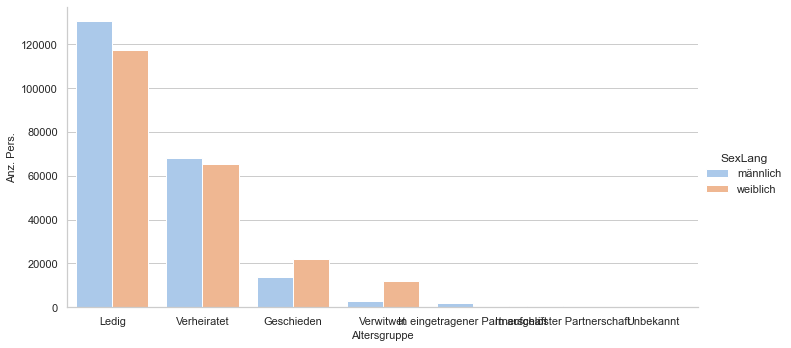

In [75]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Ziv2Lang"
            , y="sum_WBev"
            , hue="SexLang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Altersgruppe', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [79]:
data2betested.columns

Index(['Ziv2Sort', 'Ziv2Lang', 'SexCd', 'SexLang', 'QuarSort', 'QuarLang', 'AlterVSort',
       'AlterV05Sort', 'AlterV05Kurz', 'AlterV10Sort', 'AlterV10Kurz', 'AlterV20Sort',
       'AlterV20Kurz', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

In [87]:
myAggBar = data2betested\
    .groupby(['StichtagDatJahr', 'Ziv2Sort', 'Ziv2Lang', 'SexCd', 'SexLang', 'AlterV10Sort', 'AlterV10Kurz']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 
myAggBar

,,,,,,,sum_WBev
StichtagDatJahr,Ziv2Sort,Ziv2Lang,SexCd,SexLang,AlterV10Sort,AlterV10Kurz,
1998-01-01,2,Verheiratet,1,männlich,11,100 u. älter,0
1997-01-01,1,Ledig,1,männlich,11,100 u. älter,0
2012-01-01,5,In eingetragener Partnerschaft,2,weiblich,2,10-19,0
1996-01-01,1,Ledig,1,männlich,11,100 u. älter,0
2009-01-01,5,In eingetragener Partnerschaft,1,männlich,2,10-19,1
...,...,...,...,...,...,...,...
2017-01-01,1,Ledig,1,männlich,3,20-29,33014
2018-01-01,1,Ledig,1,männlich,3,20-29,33219
2020-01-01,1,Ledig,1,männlich,3,20-29,33431


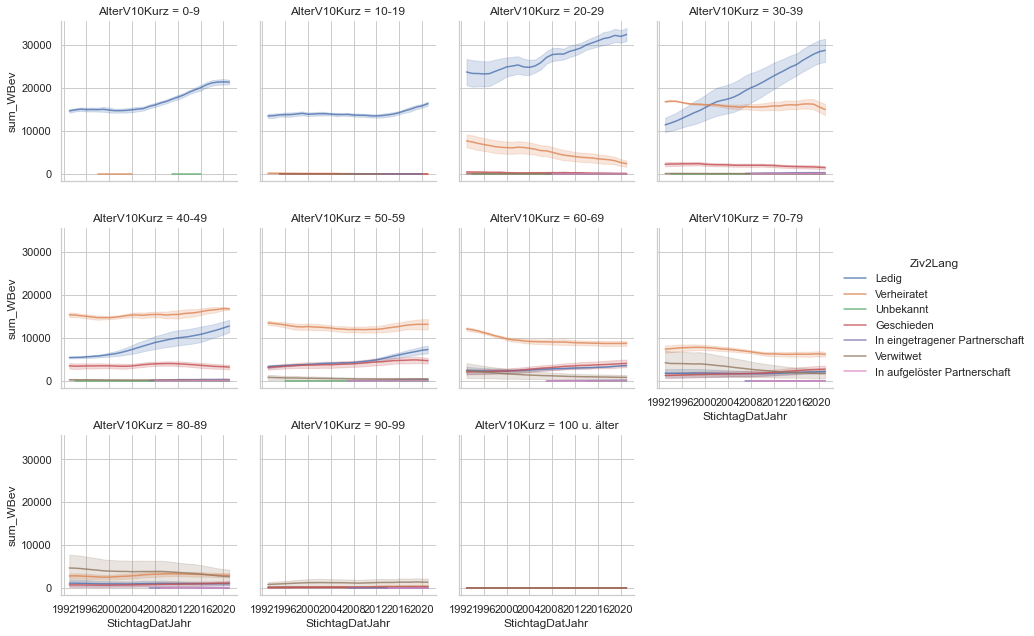

In [90]:
g2 = sns.FacetGrid(myAggBar.reset_index().sort_values('AlterV10Sort', ascending=True), col="AlterV10Kurz", hue="Ziv2Lang", col_wrap=4, height=3,)
g2.map(sns.lineplot, "StichtagDatJahr","sum_WBev",alpha=.8)

g2.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Quartier, Herkunft und Geschlecht

In [92]:
data2betested.columns

Index(['Ziv2Sort', 'Ziv2Lang', 'SexCd', 'SexLang', 'QuarSort', 'QuarLang', 'AlterVSort',
       'AlterV05Sort', 'AlterV05Kurz', 'AlterV10Sort', 'AlterV10Kurz', 'AlterV20Sort',
       'AlterV20Kurz', 'AnzBestWir', 'StichtagDatJahr_str'],
      dtype='object')

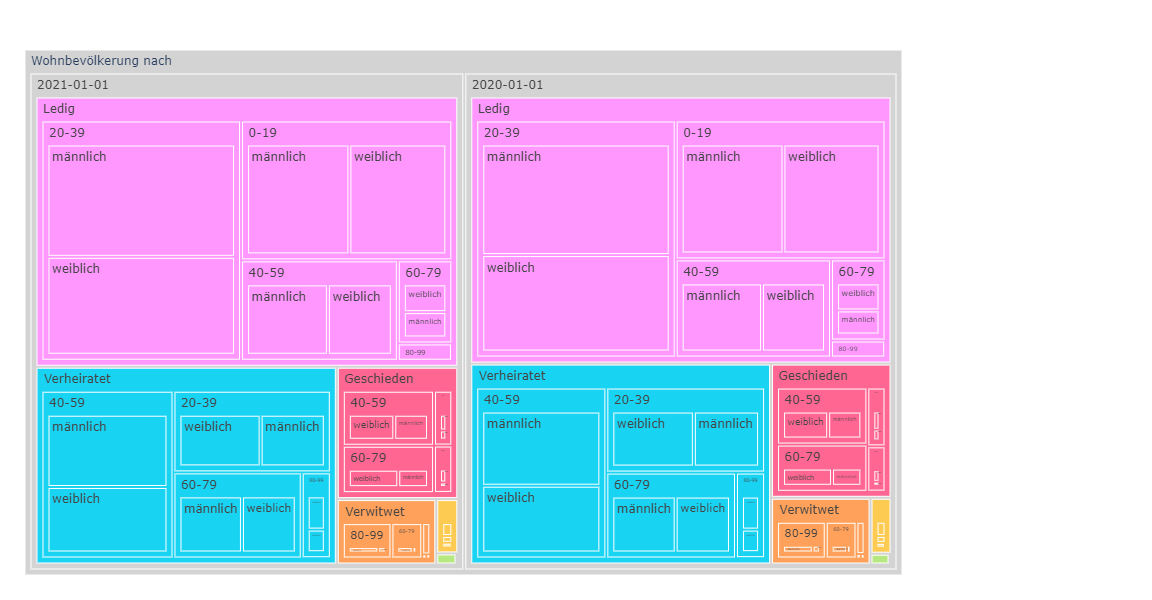

In [110]:
myTreemapAgg = data2betested.loc['2020':'2021']  \
    .groupby(['StichtagDatJahr', 'Ziv2Lang', 'SexLang','AlterV20Sort','AlterV20Kurz']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant("Wohnbevölkerung nach "), 'StichtagDatJahr', 'Ziv2Lang', 'AlterV20Kurz','SexLang']
                 , values='sum_WBev'
                 , color='Ziv2Lang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'Ausländer/in':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }         
                 , color_discrete_map={'(?)':'lightgrey','Schweizer/in':'gold', 'SP':'#FF3030' }               
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])   
                 ,height=600
                 ,width=1100
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [111]:
#data2betested.dtypes

## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=931&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [94]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [95]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [96]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [98]:
m = leafmap.Map()

#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [109]:
#data2betested.dtypes
data2betested.head()

,QuarSort,QuarCd,QuarLang,AlterVSort,AlterVCd,AlterVKurz,AlterV05Sort,AlterV05Kurz,HerkunftLang,HerkunftCd,HerkunftSort,SexCd,SexKurz,AnzBestWir
StichtagDatJahr,,,,,,,,,,,,,,
1993-01-01,11,11,Rathaus,0,0,0,1,0-4,Schweizer/in,1,1,1,M,11
1993-01-01,11,11,Rathaus,0,0,0,1,0-4,Schweizer/in,1,1,2,W,8
1993-01-01,11,11,Rathaus,0,0,0,1,0-4,Ausländer/in,2,2,1,M,1
1993-01-01,11,11,Rathaus,0,0,0,1,0-4,Ausländer/in,2,2,2,W,6
1993-01-01,11,11,Rathaus,1,1,1,1,0-4,Schweizer/in,1,1,1,M,11


In [123]:
myAgg = data2betested.loc["2020"]  \
    .copy() \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_AnzBestWir=('AnzBestWir', 'sum')) \
    .assign() \
    .sort_values('QuarCd', ascending=False) 

#myAgg.reset_index()


In [124]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


#### Leftjoin 
Matche die statistischen Daten mit den Geodaten

In [131]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd', how="left") #'right', 'inner', 'left'
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_AnzBestWir
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,7396
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,5562


In [133]:
#does all match?
gdf_adm_statistische_quartiere_map_joined.isnull().sum()

geometry          0
QuarCd            0
qname             0
knr               0
sum_AnzBestWir    0
dtype: int64

<AxesSubplot:>

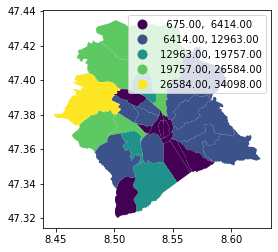

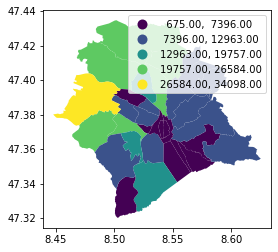

In [137]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', cmap='viridis', scheme='fisherjenks', legend=True )

#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

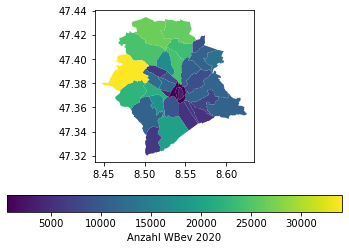

In [141]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', ax=ax, legend=True, legend_kwds={'label': "Anzahl WBev 2020",'orientation': "horizontal"})
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', ax=ax, legend=False, legend_kwds={'label': "Anzahl WBev 2020",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=115&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**